Exam no.: Y3888434

# Setup

## Colab Installs & Imports

In [5]:
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install deap
!pip install seaborn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import operator
import pygraphviz as pgv


from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from deap import gp

from functools import partial

from scipy import stats

import pandas as pd

## Manipulate Dataset

### Exploring the Data
For reference of what is being worked with

In [7]:
eScooterDF = pd.read_csv("drive/MyDrive/eScooterDemand.csv")
print("Size: %d" % len(eScooterDF))
print("First date recorded: ", eScooterDF["Date"][0])
print("Last date recorded: ", eScooterDF["Date"][len(eScooterDF)-1])
print("Total days recorded: %d" % len(eScooterDF["Date"].unique()))
print(eScooterDF.head())
print("\nMin Values\n-----------")
print(eScooterDF.min())
print("\n\nMax Values\n-----------")
print(eScooterDF.max())

Size: 8760
First date recorded:  01/12/2017
Last date recorded:  30/11/2018
Total days recorded: 365
         Date  Count  Hour  Temp  Humidity  Wind speed  Visibility  Dew point  \
0  01/12/2017    254     0  -5.2        37         2.2        2000      -17.6   
1  01/12/2017    204     1  -5.5        38         0.8        2000      -17.6   
2  01/12/2017    173     2  -6.0        39         1.0        2000      -17.7   
3  01/12/2017    107     3  -6.2        40         0.9        2000      -17.6   
4  01/12/2017     78     4  -6.0        36         2.3        2000      -18.6   

   Sunshine  Rain  Snow  Season Public Holiday HireAvailable  
0       0.0   0.0   0.0  Winter             No           Yes  
1       0.0   0.0   0.0  Winter             No           Yes  
2       0.0   0.0   0.0  Winter             No           Yes  
3       0.0   0.0   0.0  Winter             No           Yes  
4       0.0   0.0   0.0  Winter             No           Yes  

Min Values
-----------
Date      

<Axes: >

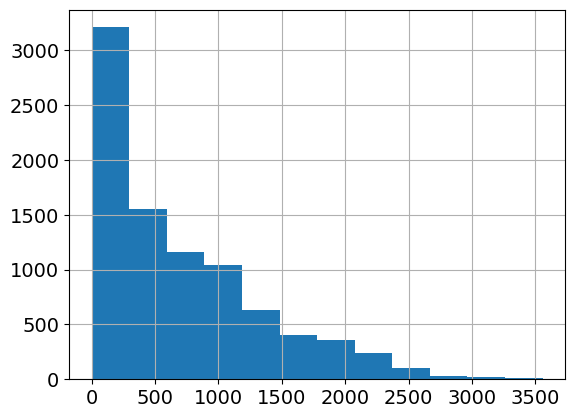

In [115]:
eScooterDF["Count"].hist(bins=12)

Clearly the counts of rented escooters are not normally distributed. Knowing this is useful for statistical testing, as t-tests are reliant on the assumption that data is normally distributed.

### Transforming Non-Numerical Data
The data has non-numerical data which may be useful to the model, so I've chosen to transform the data. Seasons are labelled 1-4 from Spring-Winter; dates have been reduced to just the month, as this captures sub-divisions of time through the seasons which might be a factor for rentals. Day and year could be represented with new columns, but were omitted for model simplicity

In [8]:
# Define transformation functions
def transform_season(s):
  match s:
    case "Spring":
      return 1
    case "Summer":
      return 2
    case "Autumn":
      return 3
    case "Winter":
      return 4

def transform_date(d):
  return int(d.split("/")[1])

In [9]:
transformed_df = eScooterDF.copy()
transformed_df["Season"] = transformed_df["Season"].apply(transform_season)
transformed_df["Public Holiday"] = transformed_df["Public Holiday"] .apply(lambda h: 0 if h == "No" else 1)
transformed_df["HireAvailable"] = transformed_df["HireAvailable"] .apply(lambda h: 0 if h == "No" else 1)
transformed_df["Date"] = transformed_df["Date"] .apply(transform_date)
#transformed_df["Temp"] = transformed_df["Temp"] + 273.15 # Convert to Kelvin to remove negative values
#transformed_df["Dew point"] = transformed_df["Dew point"] + 273.15 # Convert to Kelvin to remove negative values
transformed_df = transformed_df.rename(columns={"Date": "Month"})

In [10]:
transformed_df.head(10)

,Month,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,12,254,0,-5.2,37,2.2,2000,-17.6,0.00,0.0,0.0,4,0,1
1,12,204,1,-5.5,38,0.8,2000,-17.6,0.00,0.0,0.0,4,0,1
2,12,173,2,-6.0,39,1.0,2000,-17.7,0.00,0.0,0.0,4,0,1
3,12,107,3,-6.2,40,0.9,2000,-17.6,0.00,0.0,0.0,4,0,1
4,12,78,4,-6.0,36,2.3,2000,-18.6,0.00,0.0,0.0,4,0,1
5,12,100,5,-6.4,37,1.5,2000,-18.7,0.00,0.0,0.0,4,0,1
6,12,181,6,-6.6,35,1.3,2000,-19.5,0.00,0.0,0.0,4,0,1
7,12,460,7,-7.4,38,0.9,2000,-19.3,0.00,0.0,0.0,4,0,1
8,12,930,8,-7.6,37,1.1,2000,-19.8,0.01,0.0,0.0,4,0,1
9,12,490,9,-6.5,27,0.5,1928,-22.4,0.23,0.0,0.0,4,0,1


In [11]:
# Create a copy of the dataframe without the Count column
nocount_df = transformed_df.iloc[:, (x for x in range(0, len(transformed_df.columns)) if x != 1)]

### Split test/train data

In [12]:
train_sample = 0.4 # % of data for training
train_set = nocount_df.sample(frac=train_sample, random_state=0)#.reset_index(drop=True)
test_set = nocount_df.drop(train_set.index)#.reset_index(drop=True)

In [13]:
# Checking that the samples have a fair distribution of values. Not a perfect way to verify that both sets contain a similar variety of data but at least provides some small assurance
print(train_set["Season"].value_counts())
print(test_set["Season"].value_counts())

Season
1    883
2    883
3    877
4    861
Name: count, dtype: int64
Season
1    1325
2    1325
3    1307
4    1299
Name: count, dtype: int64


In [14]:
train_answers = eScooterDF.loc[train_set.index]["Count"]
test_answers = eScooterDF.loc[test_set.index]["Count"]

# Algorithm
Initially a neural network-based solution was chosen, in which individuals represented the list of weights used by the network in the hidden layer. However due to the amount of time the model took to evolve when the evolutionary algorithm was run, a genetic programming approach is being used instead. The MLP definition is here for reference.

## Definition of GP
An ephemeral constant is used

In [15]:
def protectedDiv(num, denom):
    try:
        return num / denom
    except ZeroDivisionError:
        return 1

def square(a):
  return a**2

pset = gp.PrimitiveSet("MAIN", 13)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)

#pset.addPrimitive(operator.abs, 1)
#pset.addPrimitive(square, 1)
pset.renameArguments(ARG0='month',ARG1='hour',ARG2='temp',ARG3='humidity',ARG4='wind_speed',ARG5='visibility',ARG6='dew_point',ARG7='sunshine',ARG8='rain',ARG9='snow',ARG10='season',ARG11='public_holidy',ARG12='hire_available')

pset.addEphemeralConstant("rand101", lambda: random.randint(-1,4))

/usr/local/lib/python3.10/dist-packages/deap/gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


In the primitive set are some basic operators: add, subtract, multiply, a protected division operator, and a negative function. Options such as squaring and an absolute function were tested but yielded poor results (see test history)

## Test History
All tests used the same 40/60 split of training & test data

Line graphs all plot the minimum fitness of the model over each generation. Root mean squared error has been used as the evaluation function for all tests for its computational simplicity, as well as being preferred to plain mean squared error. This is because the root of the square error reduces the impact of outliers on individuals' fitness values, making them fit more generally to the problem.

### First Version
The initial settings used a population of 50 individuals, to be optimised over 100 generations. The initial population was initialised with a tree height ranging 1-2 and a maximum height of 6. One-point crossover with a probability of 0.5, tournament selection with 3 participants, a mutation probability of 0.2 (subtree size range 0-2) with a uniform probability over any node in the tree. Mutations could replace any subtree with another random subtree of height 0-2.

An ephemeral constant ranging from integer values -1 to 4 was also used.

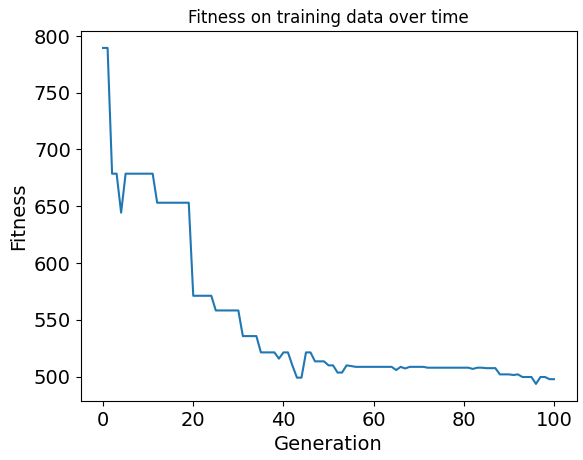

In [16]:
first_test_fitnesses = [605.9707128863328,605.6416481285679, 590.3722368425948, 582.5009778212687, 626.0424467240675]
print("Average root MSQE on test set: "+str(np.mean(first_test_fitnesses)))

Average root MSQE on test set: 602.1056044805664


The model optimised consistently across runs, trending towards a reduction in error in all cases. Occasionally the error would increase when the fittest member of the population mutated in a way that reduced its fitness, which is expected.

On the test data, the fittest individuals scored an average root mean squared error of 602.11 - quite poor. This is not too surprising, since the tree height limits the variety of input variables the model will use at its terminal nodes, so less of the data is represented when making its final prediction on the e-scooter count. The limited tree size also limits the complexity it can actually achieve.

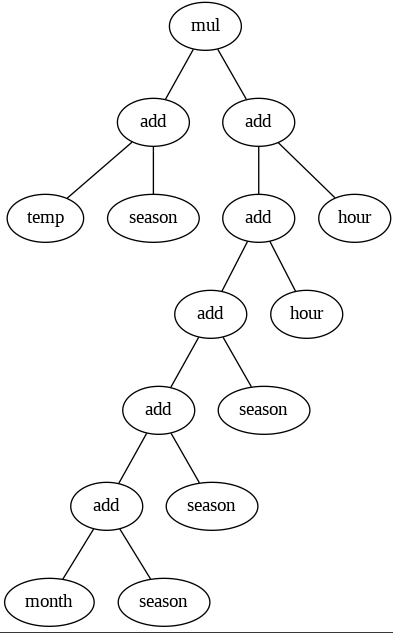

Here is a tree one of the solutions evolved. In this one we can see that not all input values were used - as expected - but there are many duplicates and not much variety in the features represented. Only 4 of the 13 potential inputs are used. This is not necessarily a failure, as some arguments are expected to have a smaller or negligable impact compared to others, and won't be represented as heavily. This particular model represents the season many times, implying that population evolved to favour it, which seems like an intuitively reasonable assumption to make given the context of the problem.

Furthermore it seems to favour the add feature of the primitive set almost exclusively. This is likely due to the fact that multiplication operations can cause the values to get out of control, especially if a potentially large value like visibility is squared, though this evolved model features a multiplication operator at the root.

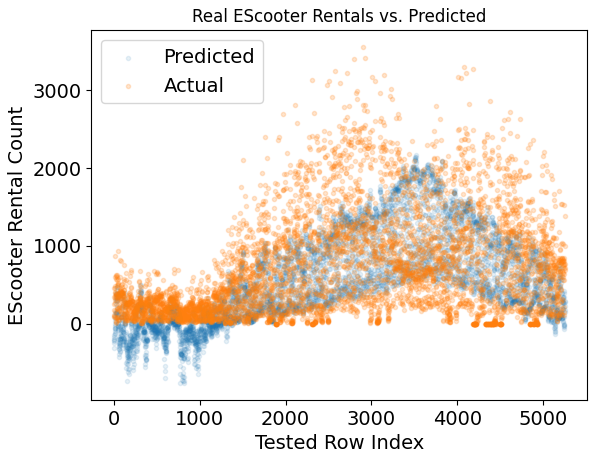

The predicted escooter counts for the test set using the evolved tree above were plotted against the real counts. For the sake of plotting, the indexes were reset to start from 0 so don't correspond exactly with the indexes in the real dataset, but they are still in the same order as the sample taken from the dataset and therefore each subsequent index represents a jump forward in time. Knowing that the first entries in the dataset start at winter and end at autumn, we can see the impact of the season on this model. The first indexes (winter & spring) are expected to have fewer scooter rentals, then as it progresses to summer it predicts more rentals, then fewer during autumn.

One problem visible in this graph is that the model is capable of predicting the rental of a negative number of scooters - an impossibility in reality. There are a few ways this could arise given the primitive set and the data used: negative and subtraction operators could create negative predictions, though neither are present in the above tree. In this case the culprit is most likely the temperature input, as we can see that the negative predictions mostly occur in winter where the temperature is expected to be negative.

One solution could be to add an absolute or squaring function to the tree's primitive set and hope that the final model evolves it in to counteract the negative temperatures. This could be unreliable between simulations, but increasing population or mutation rate might make it more likely to be represented in the fittest individual. Another solution could be converting the temperature units to Kelvin, removing negative values from the input data. The model may still create negative predictions using subtraction or negative operators from the primitive set, however.

Converting the units appeared to be a reasonable option for improving the model, so this was the first change tested. Both Temp and Dew point were converted in the same way, as both are measures of temperature using the same units.

### Temperature Units Converted to Kelvin
This change did not result in a better outcome for the model. The root MSQE on the test set measured for both this and the previous model have been compared using the Mann-Whitney U test. I chose this test because the model solutions generated by the model with different meta-parameters, or in this case a different representation of the same input data, are independent of one another, and the distribution of fitnesses which might be given by the final solutions are not guaranteed to conform to a normal distribution, so a non-parametric test is needed. This makes the Mann-Whitney U test the ideal statistical test for this case.

Thus the null hypothesis is, "The root MSQEs given by the alternative model comes from the same distribution as as root MSQEs given by the base model", or in other words, "The alternative model does not obtain significantly different results to the base model." A confidence value of 0.05 is being used to accept the alternative hypothesis.

In [17]:
kelvin_test_fitness = [675.8067015145539,708.3491321727691,709.7972158907189,662.6828278963249, 709.3351026647641]
print("Average root MSQE on test set: "+str(np.mean(kelvin_test_fitness)))

Average root MSQE on test set: 693.1941960278261


In [18]:
pv = stats.mannwhitneyu(first_test_fitnesses,kelvin_test_fitness).pvalue
print(pv)
print("Reject null hypothesis" if pv < 0.05 else "Null hypothesis cannot be rejected")

0.007936507936507936
Reject null hypothesis


We can see that the t test gave a p value far below 0.05, indicating the performance of the model using Kelvin for temperature is significantly different than the base model. Furthermore, comparing the average fitness on the test set it is evident that the results are much worse, being nearly 100 points less accurate with its prediction compared to running the model on temperatures in celsius.

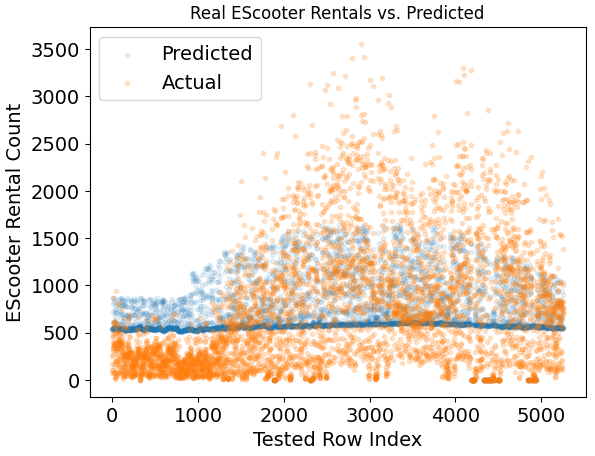

This was the final test graph produced by the alternative model, and other simulations produced very similar results. It seems that while the issue of negative values has mostly been solved, most predictions are far higher than they should be. Some negative values also still appear when trees evolve a subtract or negative operation.

### Increased Population Size
The next test involved increasing the population size, with the expectation that a larger initial population will reduce the amount of times the model stagnates during evolution as a result of selecting out most diversity. So this set of results could be compared to the better-performing base model, temperature units were left as celcius as they were for that model.

Before comparing convergence rates of the model, I started by comparing their fitness against the test set to understand if the performance was necessarily different, and thus if they generally reached the same local optimums or not.

In [93]:
plusPop_test_fitnesses = [592.2524567557862, 608.7582326329106, 558.0038882104593, 579.7472860968351, 566.1358152585766]
print("Average root MSQE on test set: "+str(np.mean(plusPop_test_fitnesses)))

Average root MSQE on test set: 580.9795357909136


In [94]:
pv = stats.mannwhitneyu(first_test_fitnesses,plusPop_test_fitnesses).pvalue
print(pv)
print("Reject null hypothesis" if pv < 0.05 else "Null hypothesis cannot be rejected")

0.2222222222222222
Null hypothesis cannot be rejected


As there is no significant statistical difference in performance on the test data, as the p value > confidence value, the performance of both models can be expected to be roughly the same.

Since we can expect both versions of the model to reach a similar local optimum, I have chosen to compare convergence rates towards a convergence point of a root MSQE of less than or equal to 550 on the training data. This is because the models tend to plateu around a root MSQE of 450-500, so setting the convergence point at this value should ensure runs actually reach this value or lower.

In [95]:
first_test_convergence_gens = [38, 40, 17, 59, 100]
plusPop_convergence_gens = [12, 7, 14, 27, 10]
print("Average generations taken to reach 550 root MSQE on training set for 50 pop: "+str(np.mean(first_test_convergence_gens)))
print("Average generations taken to reach 550 root MSQE on training set for 100 pop: "+str(np.mean(plusPop_convergence_gens)))

Average generations taken to reach 550 root MSQE on training set for 50 pop: 50.8
Average generations taken to reach 550 root MSQE on training set for 100 pop: 14.0


Null hypothesis: An larger population does not improve speed of convergence

Alternative hypothesis: A larger population increases the speed of convergence

In [96]:
pv = stats.mannwhitneyu(first_test_convergence_gens,plusPop_convergence_gens).pvalue
print(pv)
print("Reject null hypothesis" if pv < 0.05 else "Null hypothesis cannot be rejected")

0.015873015873015872
Reject null hypothesis


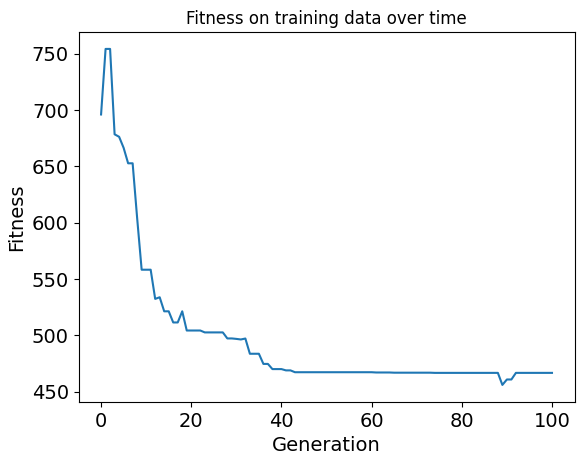

When comparing the final training fitness graph yielded by the 100 population model to the graph from the final test of the first version, it is easy to see that the slope is steeper towards the beginning, with less flat plateus in the early stages of training. However there are certain simulations of 50 population which reached the convergence point much faster than 100 pop, or vice versa, a result of the effect of mutation on the models' evolution that occasionally cause sudden improvements or losses to fitness.

Another test was conducted by doubling the population again from 100 to 200, to see if increasing it further gave diminishing returns.

In [97]:
plusPlusPop_convergence_gens = [8, 13, 17, 12, 9]
print("Average generations taken to reach 550 root MSQE on training set for 200 pop: "+str(np.mean(plusPlusPop_convergence_gens)))

Average generations taken to reach 550 root MSQE on training set for 200 pop: 11.8


Null hypothesis: Population size has diminishing returns and increasing it further does not increase the speed of convergence

Alternative hypothesis: An even larger population still increases the speed of convergence

In [98]:
pv = stats.mannwhitneyu(plusPop_convergence_gens,plusPlusPop_convergence_gens).pvalue
print(pv)
print("Reject null hypothesis" if pv < 0.05 else "Null hypothesis cannot be rejected")

0.9165626446795413
Null hypothesis cannot be rejected


With such a high p-value it is highly likely that doubling the population a second time did not significantly improve the convergence rate of the model at all, suggesting that population size does in fact have diminishing returns.

### Expanded Primitive Set
I tried adding an abs() and square() function to the primitive set of the model in the hopes that these features would be evolved to correct negative values and thus improve fitness. Two fitnesses are measure here: one is a list of fitnesses on the test set across five runs, and the other exclusively consists of fitnesses for runs which evolved at least one feature from the expanded primitive set.

In [26]:
plusPset_test_fitnesses = [568.1062877809889, 606.4046075512296, 581.0610073067446, 589.3232990126323, 654.2470730857967]
plusPsetEvo_test_fitnesses = [606.4046075512296, 589.3232990126323, 654.2470730857967, 657.4136445579246, 614.5843082596942]
print("Average root MSQE on test set across 5 runs: "+str(np.mean(plusPset_test_fitnesses)))
print("Average root MSQE on test set across 5 runs which evolved at least 1 abs/square node: "+str(np.mean(plusPsetEvo_test_fitnesses)))

Average root MSQE on test set across 5 runs: 599.8284549474783
Average root MSQE on test set across 5 runs which evolved at least 1 abs/square node: 624.3945864934556


In [44]:
pv = stats.mannwhitneyu(plusPset_test_fitnesses,first_test_fitnesses).pvalue
print(pv)
print("Reject null hypothesis" if pv < 0.05 else "Null hypothesis cannot be rejected")
pv = stats.mannwhitneyu(plusPsetEvo_test_fitnesses,first_test_fitnesses).pvalue
print(pv)
print("Reject null hypothesis" if pv < 0.05 else "Null hypothesis cannot be rejected")

0.6904761904761905
Null hypothesis cannot be rejected
0.2222222222222222
Null hypothesis cannot be rejected


For both t tests we can see that the difference in fitness is not statistically significant, even for the runs which did evolve the new features. It may be that there were too few additions to the primitive set to be adequetely represented across the populationl; the added features may not have been statistically powerful enough; or the new features were undesirable to the model and were mostly ignored or evolved into a branch which did not impact the predicted value very much, so did not end up differing greatly from solutions evolved from the smaller primitive set.

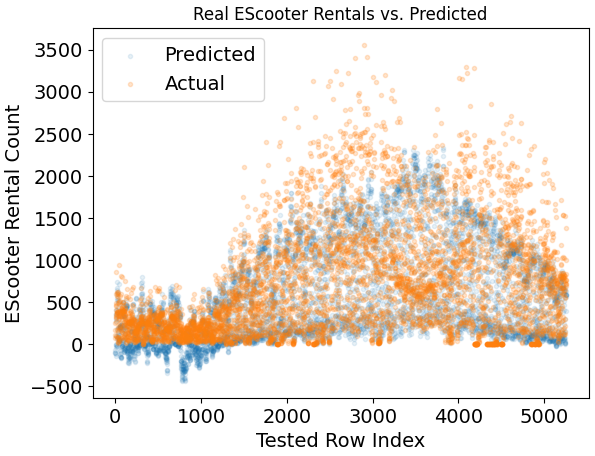

It is clear that the model did not evolve the new features to explicitly correct negative predictions. This is understandable, since the number of negative values predicted by the model is small compared to the rest of the predictions it is making, so in order to optimise the fitness function it is likely to try and evolve features to improve the accuracy of its already-close-to-correct predictions, which are much greater in number.

### Higher Mutation rate
Mutation rate boosted from 0.2 to 0.6

In [99]:
highMut_test_fitnesses=[615.0146935722664, 616.6043354428123, 647.1730689576814, 631.2554290891635, 630.226146534921]
print("Average root MSQE on test set: "+str(np.mean(highMut_test_fitnesses)))

Average root MSQE on test set: 628.054734719369


In [92]:
pv = stats.mannwhitneyu(highMut_test_fitnesses,first_test_fitnesses).pvalue
print(pv)
print("Reject null hypothesis" if pv < 0.05 else "Null hypothesis cannot be rejected")

0.031746031746031744
Reject null hypothesis


Since the p-value is lower than the chosen confidence value, we can conclude that the higher mutation rate gives significantly different results. Furthermore, the mean fitness achieved on the test set is worse with the higher mutation rate. Increasing the mutation rate effectively makes the algorithm more like a random search that is not as dictated by the fitness/evaluation function. It is possible to evolve a good solution by combining elements purely randomly, but it is incredibly unlikely and a the generally worse performance of the high-mutation model indicates that a good solution does not tend to get evolved with a mutation rate that is too high.

## Final Genetic Algorithm
- population=100
-cxpb=0.5
-mutpb=0.2
-ngen=100
-tournsize=3



### Creator + Toolbox
Individuals are represented as trees of operations. The input values are the terminal nodes, and some simple mathematical operations make up the primitive set.

In [28]:
creator.create("Fitness", base.Fitness, weights=(-1.0,)) # Minimise error of predicted value
creator.create("Individual", gp.PrimitiveTree, fitness=creator.Fitness) # Individuals as <TYPE>

In [100]:
toolbox = base.Toolbox()

# Basic attributes
toolbox.register("attr_float", random.uniform, -1, 1)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)

# Fitness, selection, crossover & mutation
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Population representation
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Compile
toolbox.register("compile", gp.compile, pset=pset)

# Contraint for faster tessting
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=6))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=6))

### Evaluation Function
Root mean squared error is being used as the evaluation metric for simplicity. Rooting the squared error gives less weighting to outliers and should make the model fit more generally.

In [101]:
"""
# MLP Evaluation
def evaluate(individual,perceptron):
  perceptron.setWeightsLinear(individual)
  error = 0
  for i in train_set.index:
    result = perceptron.feedForward(train_set.iloc[i].tolist())
    error += abs(result**2 - eScooterDF.loc[i]["Count"]**2)
  return (error/len(train_set))**0.5,"""

'\n# MLP Evaluation\ndef evaluate(individual,perceptron):\n  perceptron.setWeightsLinear(individual)\n  error = 0\n  for i in train_set.index:\n    result = perceptron.feedForward(train_set.iloc[i].tolist())\n    error += abs(result**2 - eScooterDF.loc[i]["Count"]**2)\n  return (error/len(train_set))**0.5,'

In [102]:
# mean squared error
def evaluate(individual):
  func = toolbox.compile(expr=individual)
  results = train_set.apply(lambda row: func(*row), axis=1)
  error = (((results - train_answers)**2).sum() / len(train_set))**0.5
  return error,

# run individual on test set
def test(individual):
  func = toolbox.compile(expr=individual)
  results = test_set.apply(lambda row: func(*row), axis=1)
  error = (((results - test_answers)**2).sum() / len(train_set))**0.5
  return error,

In [103]:
toolbox.register("evaluate", evaluate)

### Generate & Test Population

In [104]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

In [105]:
pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, stats=mstats,
                                   halloffame=hof, verbose=True)

   	      	                    fitness                    	                     size                     
   	      	-----------------------------------------------	----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std    	avg 	gen	max	min	nevals	std   
0  	100   	1426.14	0  	31717.6	788.829	100   	3267.78	3.45	0  	7  	2  	100   	1.4239
1  	64    	930.583	1  	1080.25	754.272	64    	32.171 	3.61	1  	9  	1  	64    	1.74869
2  	56    	1124.8 	2  	17475.8	683.879	56    	1674.26	3.36	2  	9  	1  	56    	1.77494
3  	62    	5012.5 	3  	407192 	683.879	62    	40422.6	3.82	3  	12 	1  	62    	2.43467
4  	63    	927.652	4  	4891.25	683.879	63    	404.222	4.24	4  	18 	1  	63    	3.00373
5  	64    	1643.44	5  	34525.2	678.663	64    	4468.8 	4.78	5  	19 	1  	64    	3.50594
6  	49    	1603.26	6  	75517.4	678.663	49    	7445.19	4.86	6  	11 	1  	49    	2.73503
7  	64    	1851.02	7  	69204.3	678.663	64    	7144.1 	5.12	7  	16 	1  	64    	3.03737
8  	64    	1692.

## Result Analysis

In [106]:
gen = log.chapters['fitness'].select("gen")
_min = log.chapters['fitness'].select("min")
_max = log.chapters['fitness'].select("max")
avgs = log.chapters['fitness'].select("avg")
stds = log.chapters['fitness'].select("std")

### Fitness Change During Training

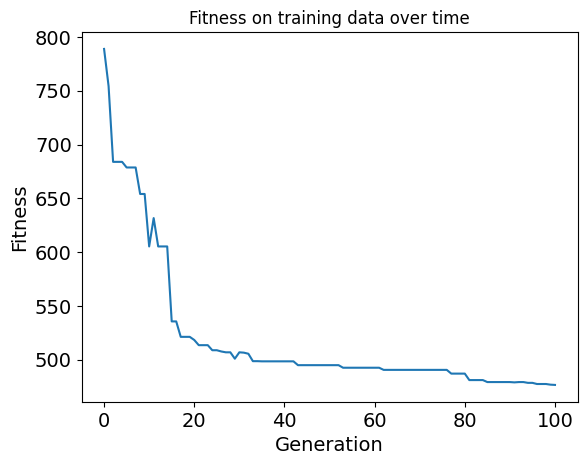

In [107]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
#line1 = ax1.plot(gen, avgs)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")
ax1.set_title("Fitness on training data over time")

line2 = ax1.plot(gen, _min)
#line3 = ax1.plot(gen, _max)

In [108]:
indv = tools.selBest(pop, 1)[0]
print(indv)

mul(add(wind_speed, add(add(sub(sub(temp, rain), rain), add(temp, sub(wind_speed, dew_point))), add(sub(sub(temp, rain), rain), add(temp, sub(wind_speed, dew_point))))), hour)


In [109]:
nodes, edges, labels = gp.graph(indv)

tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

### Final Tree

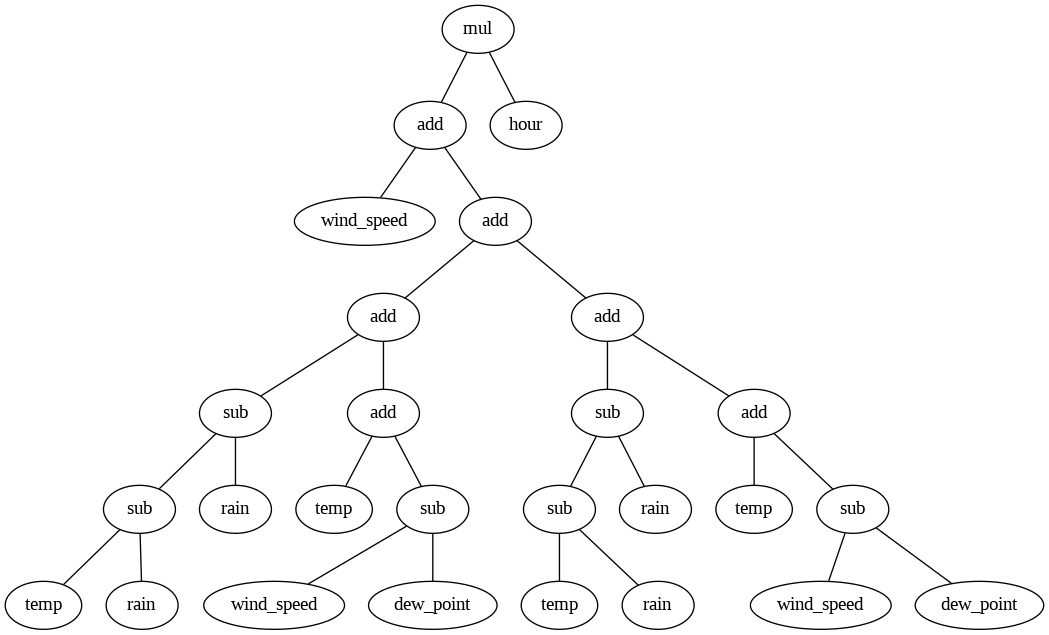

In [110]:
from IPython.display import Image

treePlot = tree.draw(format='png', prog='dot')
Image(treePlot)

### Fitness of Fittest Individual on Test Set

In [111]:
test(indv)

(597.2769120412526,)

### Plot of Predictions Vs. Real Values

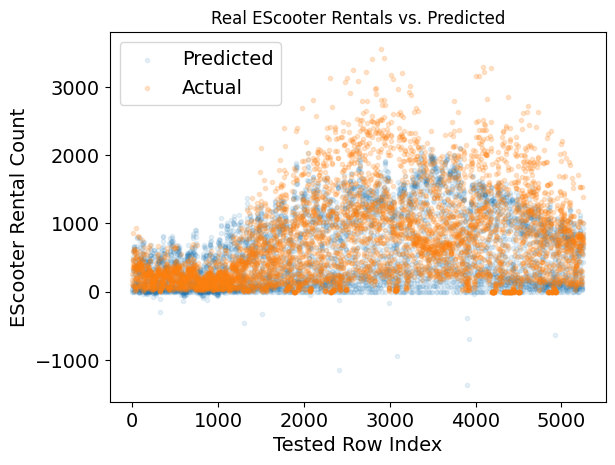

In [112]:
func = toolbox.compile(expr=indv)
results = test_set.apply(lambda row: func(*row), axis=1).reset_index(drop=True)
fig, ax2 = plt.subplots()
ax2.scatter(results.index, results.tolist(), alpha=0.1, label="Predicted", marker=".")
scatter = ax2.scatter(results.index, test_answers.reset_index(drop=True).tolist(), alpha=0.2, label="Actual", marker=".")
ax2.set_xlabel("Tested Row Index")
ax2.set_ylabel("EScooter Rental Count")
ax2.set_title("Real EScooter Rentals vs. Predicted")

ax2.legend()

plt.show()

While it is not expected for the predicted results to fit perfectly to the real ones, a Mann-Whitney U can tell us if the two sets of results might come from a similar distribution, and thus if the predictions are acceptable for practical use given the current data.

In [116]:
stats.mannwhitneyu(results, test_answers)

MannwhitneyuResult(statistic=12668518.0, pvalue=1.9040201186971958e-13)

# Evaluation of Final Solution

The model evolves quickly at the start, creating an individaul that achieves a good fitness on the training data in only a few generations, who is improved upon marginally with later generations of the model. The fitness on the test set is not amazing, but not wildly far from the fitness achieved on the training set, so the model has generalised to a fair degree and not overfitted on the training data.

A few faults are evident with the final individual. Firstly, its genetic program tree contains a number of add and subtract terms for the same inputs which cancel out one another, adding complexity that does not affect the performance of the individual in evaluation. Secondly, negative value predictions exist (see scatter graph) and some are quite extreme. These negative answers are invalid answers for the problem the model is designed to solve.

As the values predicted by the model are so different to the true values, the Mann-Whitney U test gives an exceedingly small p-value, indicating there is hardly any similarity in the numbers at all. Therefore the genetic model cannot reasonably be used as a predictor for Escooter rentals.